# RNNs Model


In [259]:
from argparse import Namespace
import os
import json
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Vocabulary, Vectorizer, Dataset

In [260]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """    
        # _token_to_idx for text_vocab:
        #   {'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'T': 4, 'o': 5, 't': 6, 'a': 7, ....., 'Á': 79}
        # _idx_to_token: 
        #   {0:'<MASK>'0, 1:'<UNK>', 2:'<BEGIN>',   3:'<END>',   4:'T',  5:'o',  6:'t',  7:'a',....., 79:'Á'}
            
        # _token_to_idx category_vocab: {'Arabic': 0, 'Chinese': 1, ..., 'Vietnamese': 17}
        # _idx_to_token:                   {0:'Arabic',  1:'Chinese', ...,  17:'Vietnamese'}

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         
                                                  
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [261]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token  # for paddding, e.g., 'McMahan' -> [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0]
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)           # mask_index is 0
        self.unk_index = self.add_token(self._unk_token)             # unk_index is 1
        self.begin_seq_index = self.add_token(self._begin_seq_token) # begin_seq_index is 2
        self.end_seq_index = self.add_token(self._end_seq_token)     # end_seq_index is 3

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [262]:
class SpamVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, text_vocab, category_vocab):
        """
        Args:
            text_vocab (Vocabulary): maps characters to integers
            category_vocab (Vocabulary): maps nationalities to integers
        """
        self.text_vocab = text_vocab
        self.category_vocab = category_vocab

    def vectorize(self, text, vector_length=-1):
        """
        Args:
            text (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """        
        indices = [self.text_vocab.begin_seq_index]
        indices.extend(self.text_vocab.lookup_token(token) 
                       for token in text.split(" "))
        indices.append(self.text_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)   # SpamDataset._max_seq_length is 19 in current dataset.      
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.text_vocab.mask_index
        
        return out_vector, len(indices)
    
    @classmethod
    def from_dataframe(cls, message_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            message_df(pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the SpamVectorizer
        """
        category_vocab = Vocabulary()        
        for category in sorted(set(message_df.label)):
            category_vocab.add_token(category)

        word_counts = Counter()
        for message in message_df.text:
            for token in message.split(" "):
                    word_counts[token] += 1
        
        text_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                text_vocab.add_token(word)
        
        return cls(text_vocab, category_vocab)

In [263]:
class SpamDataset(Dataset):
    def __init__(self, message_df, vectorizer):
        """
        Args:
            message_df(pandas.DataFrame): the dataset
            vectorizer (SpamVectorizer): vectorizer instatiated from dataset
        """
        self.message_df= message_df
        self._vectorizer = vectorizer

        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, message_df.text)) + 2
 
        self.train_df = self.message_df[self.message_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.message_df[self.message_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.message_df[self.message_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = self.train_df.label.value_counts().to_dict()   # {'English': 2972, 'Russian': 2373, ....}
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0]) # e.g, index of English is 4
        sorted_counts = sorted(class_counts.items(), key=sort_key)          # sort by the index number of category_vocab
                                   # {('Arabic', 1603), ('Chinese', 220), ('Czech', 414), ('Dutch', 236),('English', 2972), ...}
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32) # [1/1603, 1/220, 1/414, 1/236, 1/2972, ...]

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, message_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            message_csv (str): location of the dataset
        Returns:
            an instance of SpamDataset
        """
        message_df= pd.read_csv(message_csv)
        train_message_df= message_df[message_df.split=='train']
        return cls(message_df, SpamVectorizer.from_dataframe(train_message_df))
        
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        text_vector, vec_length = \
            self._vectorizer.vectorize(row.text, self._max_seq_length)
        
        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.label)

        return {'x_data': text_vector,      
                'y_target': category_index,            
                'x_length': vec_length}        
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size   

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Model

In [264]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        #if loss_t >= loss_tm1:
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [265]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [266]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1   # deduct 1 since the index starts from 0
                                                              # e.g., [9, 6, 11, 9, 7, ...., 12]
    out = []
    for batch_index, column_index in enumerate(x_lengths): # out gets the last hidden vector of each input: (batch, hidden_size)
        out.append(y_out[batch_index, column_index]) # e.g., y_out[0, 9], y_out[1, 6]

    return torch.stack(out)  # (batch, hidden_size*num_directions); E.g., (64, 64*num_direction)

def column_summation(y_out, x_lengths, mode="mean"):
    '''Get a max or mean vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the max or mean vector of all the vectors by 
    the position indicated by the corresponding value in `x_lengths` at the row index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)
        mode: "mean" for mean vector; "max" for max vector

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        if mode == "mean":
            # Get the mean vector of the current batch item from y_out and append it to out list.
            out.append(y_out[batch_index, :column_index+1].mean(dim=0))
        else:
            # Get the max vector of the current batch item from y_out and append it to out list.
            out.append(y_out[batch_index, :column_index+1].max(dim=0).values)

    return torch.stack(out)

class SpamClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, bidirectional=False, batch_first=True, padding_idx=0, dropout=0.2):
        super(SpamClassifier, self).__init__()

        if bidirectional == False:
             self.num_directions = 1
        else:
             self.num_directions = 2
        
        self.emb = nn.Embedding(num_embeddings=num_embeddings,embedding_dim=embedding_size,padding_idx=padding_idx)          
#         self.rnn = nn.RNN(input_size=embedding_size,              
        self.rnn = nn.GRU(input_size=embedding_size,
#         self.rnn = nn.LSTM(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,         
                             batch_first=batch_first, 
                             num_layers = 1,
                             dropout = 0.0, 
                             bidirectional=bidirectional)
        
        self._dropout_p = dropout
        self.fc1 = nn.Linear(in_features=rnn_hidden_size*self.num_directions, out_features=rnn_hidden_size*self.num_directions)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size*self.num_directions, out_features=num_classes)                           
        self.bn1 = nn.BatchNorm1d(rnn_hidden_size*self.num_directions) 

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
    
        x_embedded = self.emb(x_in)            
        y_out, _ = self.rnn(x_embedded)  
      
        if x_lengths is not None:        
            y_out = column_summation(y_out, x_lengths, mode="mean") 
        else:
            y_out = y_out[:, -1, :]      
            
        y_out = F.relu(self.bn1(self.fc1(F.dropout(y_out, self._dropout_p, training=self.training))))  # y_out: (64, 64*num_direction)
        y_out = self.fc2(F.dropout(y_out,self._dropout_p, training=self.training))   # y_out: (batch, num_classes) ; (64, 18)
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

## Settings

In [267]:
args = Namespace(
    # Data and path information
    message_csv="./dataset/SMSSpamCollection_Split",
    model_state_file="model.pth",
    save_dir="./model_storage/RNN",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=32,
    bidirectional=True,
    dropout=0.4,
    # Training hyper parameter
    num_epochs=100,
    learning_rate=0.001,
    batch_size=128,
    seed=1337,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: False


In [268]:
# create dataset and vectorizer
dataset = SpamDataset.load_dataset_and_make_vectorizer(args.message_csv)

vectorizer = dataset.get_vectorizer()

classifier = SpamClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.text_vocab),
                               num_classes=len(vectorizer.category_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.text_vocab.mask_index,
                               bidirectional=args.bidirectional,
                               dropout=args.dropout)

## Training Routine

In [269]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'],         # (batch, seq_size) ; e.g., (64,19)
                                x_lengths=batch_dict['x_length'])  # (batch,) ; e.g, (64,)
                                                                   # y_pred: (batch, num_classes) ; e.g., (64,18)
            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 1
        val_bar.n = 1
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

In [270]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_nationality_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])

    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
    y_nationality_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [271]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.10863878205418587;
Test Accuracy: 98.2421875


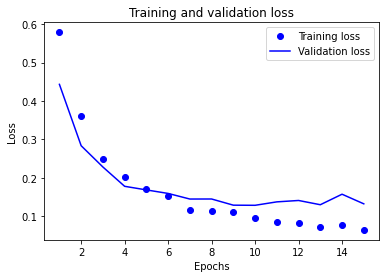

In [272]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

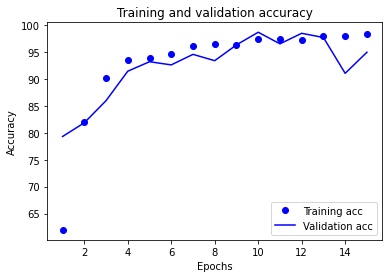

In [273]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()